In [ ]:
import pandas as pd

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import array

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import random

In [ ]:
# crear df uniendo los files de stocks y de covid
def create_dfs(nombre_pais, nombre_stock_file):
  covid = pd.read_csv('rawdata-1.csv')
  stock = pd.read_csv(nombre_stock_file)
  country = nombre_pais
  covid_filt = covid[covid['id'].isin(country)].copy()
  covid_filt['date'] = pd.to_datetime(covid_filt['date'])
  covid_filt = covid_filt[covid_filt['date'] >= '2020-01-22']
  covid_filt = covid_filt[covid_filt['date'] <= '2021-09-21']
  stock_close = stock[['Date', 'Close']].copy()
  stock_close['Date'] = pd.to_datetime(stock_close['Date'])
  covid_filt = covid_filt.merge(stock_close, left_on = 'date', right_on = 'Date').drop(['Date'], axis=1)
  return covid_filt

In [ ]:
# limpiar df
def clean_df(covid_filt):
  covid_filt["sum4index"] = (covid_filt['school_closing'] + covid_filt['cancel_events'] + covid_filt['workplace_closing'] + covid_filt['gatherings_restrictions'] + covid_filt['transport_closing'] + covid_filt['stay_home_restrictions'] + covid_filt['internal_movement_restrictions'] + covid_filt['international_movement_restrictions'])
  covid_filt['benchmarking index'] = round((covid_filt["sum4index"]* 3 ) / 20)
  covid_filt = covid_filt[["date", "vaccines", "tests", "confirmed", "deaths", "hosp", "icu", "benchmarking index", "Close"]].copy()
  to_daily = ['vaccines', 'confirmed', 'deaths', 'hosp', 'icu']

  covid_filt_daily = covid_filt.copy()
  covid_filt_daily[to_daily] = covid_filt[to_daily].diff()
  covid_filt_daily[to_daily] = covid_filt_daily[to_daily].where(covid_filt_daily[to_daily] > 0, other = 0)
  covid_filt_daily[to_daily] = covid_filt_daily[to_daily].replace(0, np.nan).ffill()
  covid_filt_daily['tests'] = (covid_filt_daily['tests'] / 7).ffill()
  df_ml = covid_filt[["vaccines", "tests", "confirmed", "deaths", "hosp", "icu", "benchmarking index", "Close"]].copy()

  return covid_filt_daily, df_ml

In [ ]:
def stat_df(df):
  print('Describe')
  print(df.describe())
  print('Corr')
  print(df.corr())
  msno.matrix(df)

In [ ]:
# visualizar df
def graph_scatter(covid_filt_daily):
  # graph scatterplots
  #sns.set(rc={'figure.figsize':(11.7,8.27)})
  i = 0
  var_x = ['date', 'Close']
  for col in covid_filt_daily.columns:
    for v in var_x:
      if col != v:
        plt.figure(i)
        sns.scatterplot(x = covid_filt_daily[v], y = covid_filt_daily[col])
        i = i + 1

In [ ]:
def graph_dist(covid_filt_daily):
  for i, col in enumerate(covid_filt_daily.select_dtypes(np.float).columns):
    plt.figure(i)
    sns.distplot(covid_filt_daily[col])

In [ ]:
# split a multivariate sequence into samples

def split_sequences(sequences, n_steps_in, n_steps_out):

	X, y = list(), list()
	for i in range(len(sequences)):

		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1

		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)

	return array(X), array(y)

In [ ]:
#Prepara los datos para la creación de secuencias y los estandariza
def prepare_data(df):
  df = df.replace(np.nan, 0)
  values = df.values
  scaler = StandardScaler()
  scaler.fit(values)
  scal_values = scaler.transform(values)
  return scal_values

In [ ]:
# Divide los datos y los separa en secuencias:
def split_data(df, in_steps, percent):
  prepare = prepare_data(df)
  X, y = split_sequences(prepare, in_steps, 1)
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = percent, random_state = 42)
  return X_train, y_train, X_val, y_val

In [ ]:
def modelo(X_train, y_train, X_test, y_test, n_layers, n_epochs, n_units, in_steps, learning):
  adam = tf.keras.optimizers.Adam(
    learning_rate=learning,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
  )
  X_train = X_train.astype("float32")
  y_train = y_train.astype("float32")
  X_test = X_test.astype("float32")
  y_test = y_test.astype("float32")
  n_features = X_train.shape[2]

  # define model
  tf.random.set_seed(42)
  model = Sequential()

  model.add(LSTM(n_units, activation='relu', input_shape=(in_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer=adam, loss='mse', metrics = ['mae'])

  # fit model

  history = model.fit(X_train, y_train, epochs=n_epochs, verbose=1, validation_data=(X_test,y_test))

  predicted_result = model.predict(X_test)

  print('R2 Score: ', r2_score(y_test, predicted_result))
  
  plt.plot(predicted_result, label='predict')
  plt.plot(y_test, label ='validation')
  plt.title("Predict / validation results")
  plt.legend()
  plt.show()

  eps = range(0, n_epochs)

  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  plt.plot(eps, loss_train, 'g', label='Training MSE')
  plt.plot(eps, loss_val, 'b', label='Validation MSE')
  plt.title('Training and Validation MSE')
  plt.xlabel('Epochs')
  plt.ylabel('MSE')
  plt.legend()
  plt.show()

  mae_train = history.history['mae']
  mae_val = history.history['val_mae']
  plt.plot(eps, mae_train, 'g', label='Training MAE')
  plt.plot(eps, mae_val, 'b', label='Validation MAE')
  plt.title('Training and Validation MAE')
  plt.xlabel('Epochs')
  plt.ylabel('MAE')
  plt.legend()
  plt.show()

  return predicted_result

In [ ]:
df_esp = create_dfs(['ESP'], 'IBEX.csv')
complete_df, cleaned_df_esp = clean_df(df_esp)

Describe
            vaccines         tests  ...  benchmarking index         Close
count     184.000000  3.640000e+02  ...          428.000000    428.000000
mean   367029.858696  3.620161e+06  ...            2.030374   8002.449998
std    211480.433640  2.636495e+06  ...            0.705623    945.556660
min     39157.000000  1.479317e+05  ...            0.000000   6107.200195
25%    151256.500000  9.166476e+05  ...            2.000000   7066.875122
50%    408358.500000  3.300663e+06  ...            2.000000   8140.799805
75%    536691.500000  6.014934e+06  ...            2.000000   8799.849609
max    765399.000000  8.221420e+06  ...            3.000000  10083.599609

[8 rows x 8 columns]
Corr
                    vaccines     tests  ...  benchmarking index     Close
vaccines            1.000000  0.565864  ...           -0.154344  0.713093
tests               0.565864  1.000000  ...           -0.460434  0.902585
confirmed          -0.181389  0.197929  ...            0.032470  0.039919
de

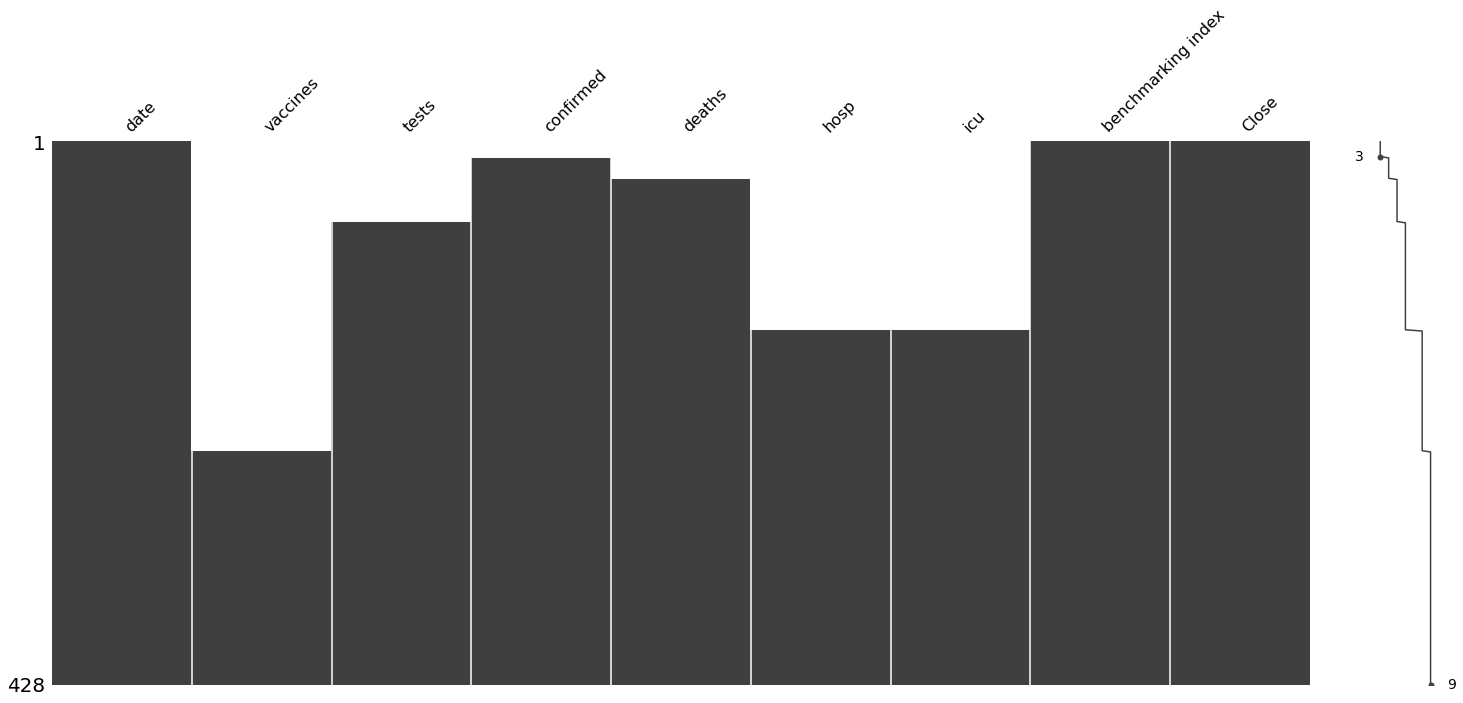

In [ ]:
stat_df(complete_df)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

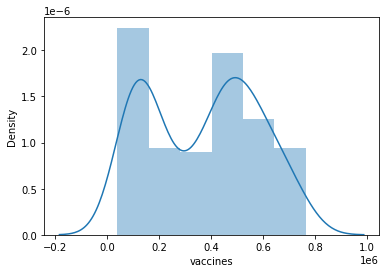

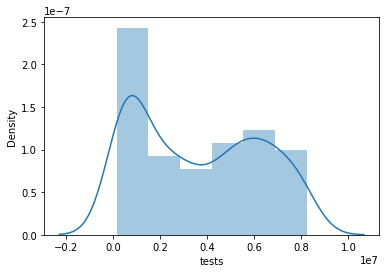

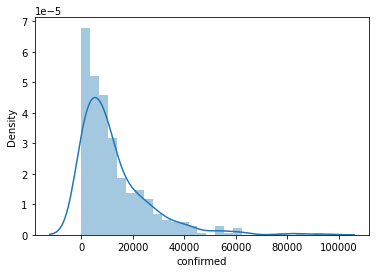

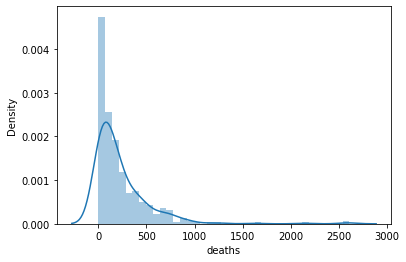

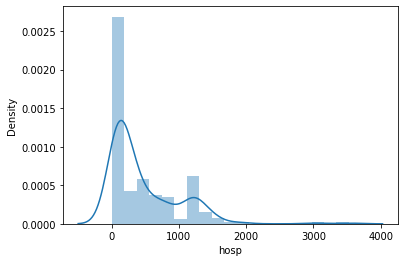

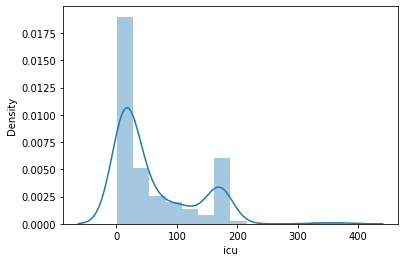

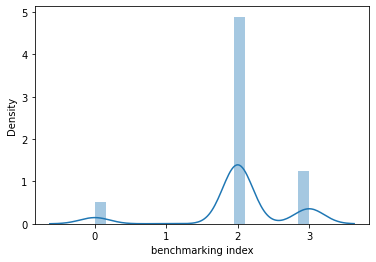

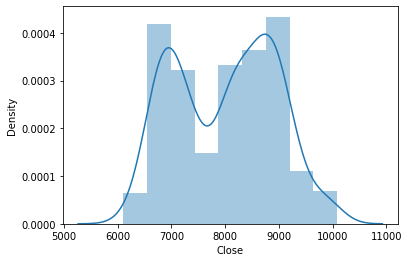

In [ ]:
graph_dist(complete_df)

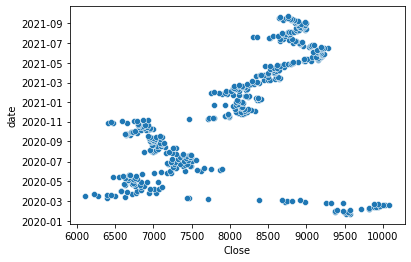

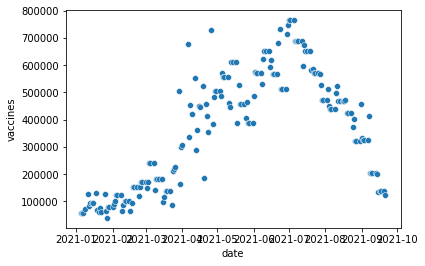

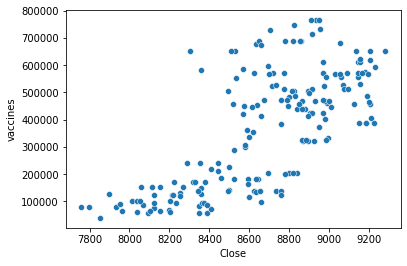

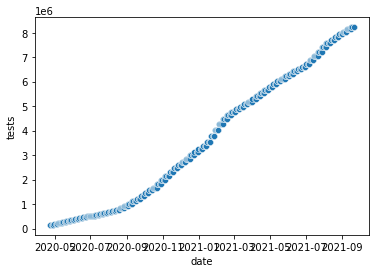

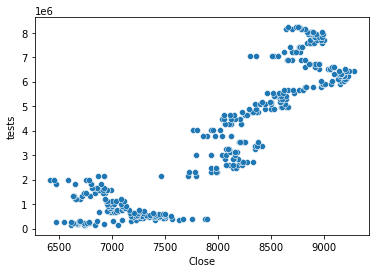

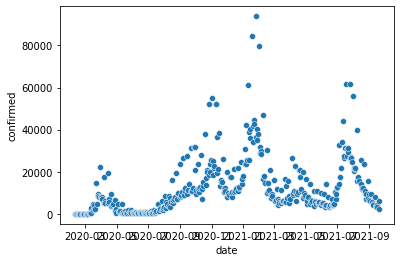

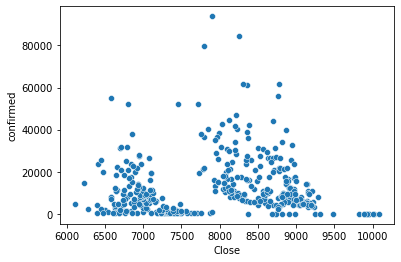

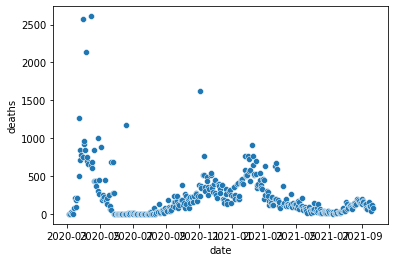

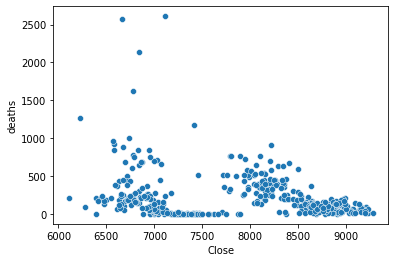

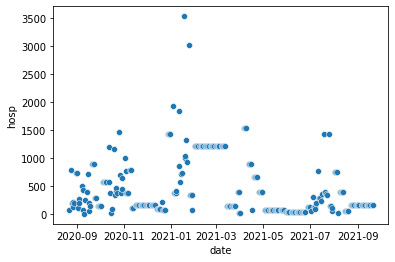

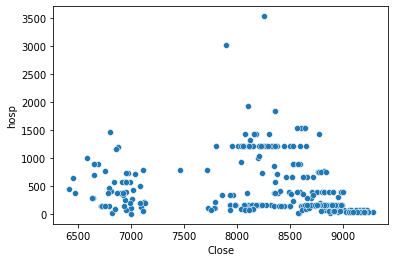

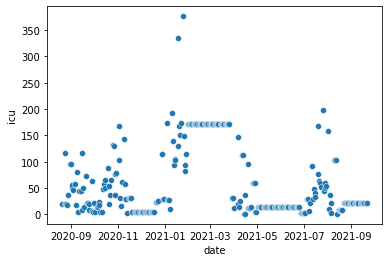

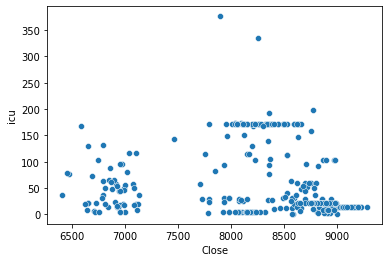

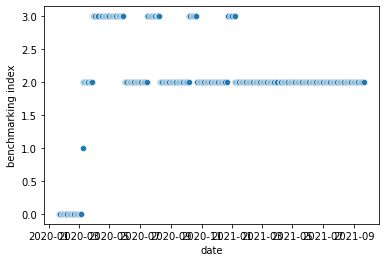

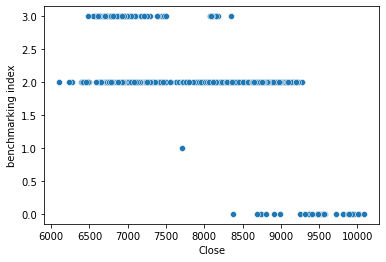

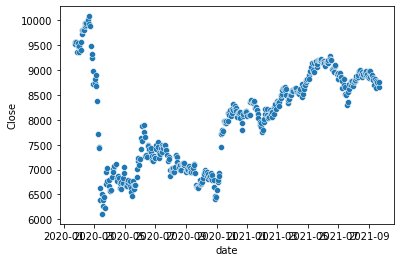

In [ ]:
graph_scatter(complete_df)

In [ ]:
X_train_esp, y_train_esp, X_val_esp, y_val_esp = split_data(cleaned_df_esp, 5, 0.2)
print(len(X_train_esp), len(y_train_esp), len(X_val_esp), len(y_val_esp))

339 339 85 85


Epoch 1/100
11/11 [==============================] - 2s 36ms/step - loss: 0.3901 - mae: 0.4708 - val_loss: 0.1869 - val_mae: 0.3148
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1529 - mae: 0.2875 - val_loss: 0.1578 - val_mae: 0.3453
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1032 - mae: 0.2503 - val_loss: 0.1193 - val_mae: 0.2731
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0971 - mae: 0.2298 - val_loss: 0.1100 - val_mae: 0.2658
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0881 - mae: 0.2211 - val_loss: 0.1103 - val_mae: 0.2568
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1126 - mae: 0.2283 - val_loss: 0.1795 - val_mae: 0.3196
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0981 - mae: 0.2276 - val_loss: 0.1826 - val_mae: 0.3235
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0899 -

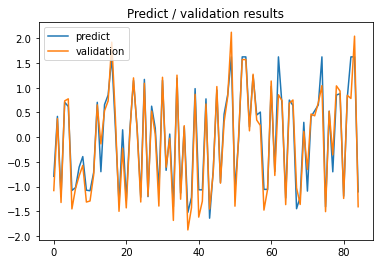

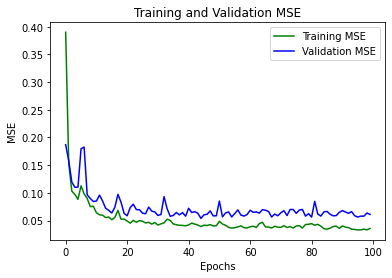

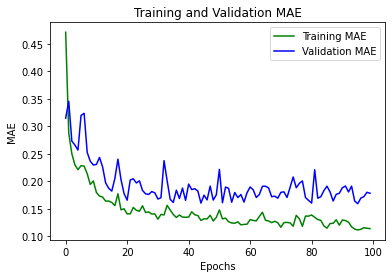

In [ ]:
esp = modelo(X_train_esp, y_train_esp, X_val_esp, y_val_esp, 1, 100, 50, 5, 0.01)

In [ ]:
df_aut = create_dfs(['AUT'], 'ATX.csv')
cleaned_df_aut = clean_df(df_aut)[1]

X_train_aut, y_train_aut, X_val_aut, y_val_aut = split_data(cleaned_df_aut, 5, 0.2)
print(len(X_train_aut), len(y_train_aut), len(X_val_aut), len(y_val_aut))

335 335 84 84


Epoch 1/100
11/11 [==============================] - 2s 48ms/step - loss: 0.3749 - mae: 0.4394 - val_loss: 0.1591 - val_mae: 0.3218
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1312 - mae: 0.2845 - val_loss: 0.1091 - val_mae: 0.2236
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.1060 - mae: 0.2341 - val_loss: 0.1161 - val_mae: 0.2289
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0676 - mae: 0.1805 - val_loss: 0.0542 - val_mae: 0.1581
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0402 - mae: 0.1423 - val_loss: 0.0700 - val_mae: 0.1619
Epoch 6/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0438 - mae: 0.1353 - val_loss: 0.0544 - val_mae: 0.1317
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.0402 - mae: 0.1319 - val_loss: 0.0638 - val_mae: 0.1386
Epoch 8/100
11/11 [==============================] - 0s 14ms/step - loss: 0.049

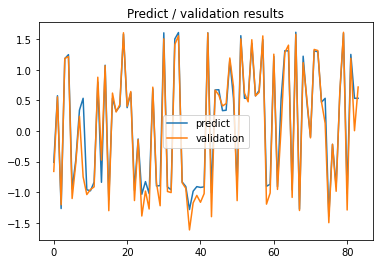

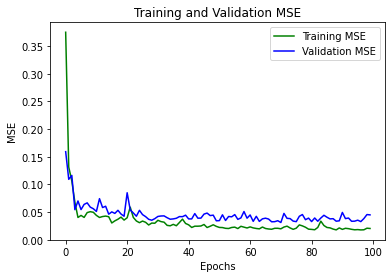

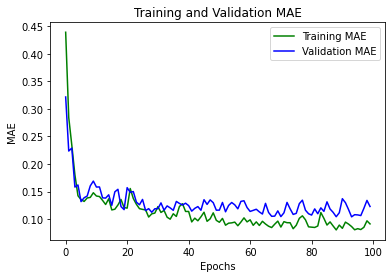

In [ ]:
aut = modelo(X_train_aut, y_train_aut, X_val_aut, y_val_aut, 1, 100, 50, 5, 0.01)

In [ ]:
df_irl = create_dfs(['IRL'], 'ISEQ.csv')
cleaned_df_irl = clean_df(df_irl)[1]

X_train_irl, y_train_irl, X_val_irl, y_val_irl = split_data(cleaned_df_irl, 5, 0.2)
print(len(X_train_irl), len(y_train_irl), len(X_val_irl), len(y_val_irl))

337 337 85 85


Epoch 1/100
11/11 [==============================] - 2s 32ms/step - loss: 0.3901 - mae: 0.4737 - val_loss: 0.1979 - val_mae: 0.3633
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1453 - mae: 0.2937 - val_loss: 0.0962 - val_mae: 0.2448
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0835 - mae: 0.2104 - val_loss: 0.0654 - val_mae: 0.1899
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0699 - mae: 0.1982 - val_loss: 0.0676 - val_mae: 0.1942
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0542 - mae: 0.1639 - val_loss: 0.0567 - val_mae: 0.1622
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0502 - mae: 0.1563 - val_loss: 0.0516 - val_mae: 0.1512
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0451 - mae: 0.1482 - val_loss: 0.0530 - val_mae: 0.1530
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0438 -

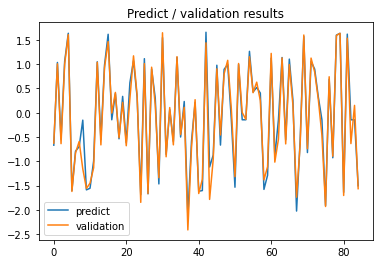

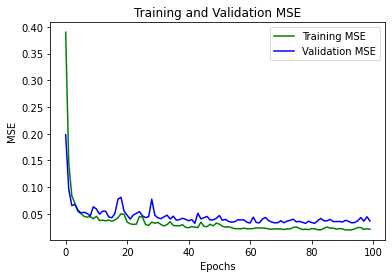

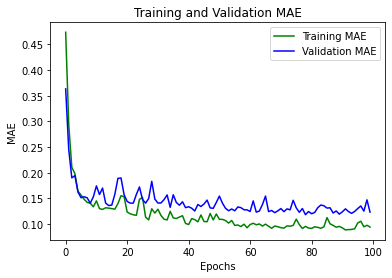

In [ ]:
irl = modelo(X_train_irl, y_train_irl, X_val_irl, y_val_irl, 1, 100, 50, 5, 0.01)